In [1]:
"""
Enhanced EV routing environments and training script.
Features added:
 - Action-masking via fixed-size neighbor-index action space (Discrete(max_degree)).
 - Fleet environment: simulate multiple EVs in one episode (FleetEVEnv).
 - Node embeddings: compute spectral embeddings (top-k eigenvectors of normalized Laplacian).
 - Debugging outputs: per-episode prints, TensorBoard logging, evaluation helper.

Usage:
 - Place this file where your project can import it (same folder as your training script).
 - Adjust `road_network` and `update_dynamic_edge_states` to your project objects.
 - Run the training block at the bottom (or import the provided functions/classes).

Note: This file keeps the API compatible with stable-baselines3 but uses an action mapping where actions are indices into the current node's neighbor list. This avoids selecting non-neighbor nodes.
"""

from typing import Dict, Any, List, Tuple, Optional
import gym
from gym import spaces
import numpy as np
import networkx as nx
import random
import math
import time
import os

from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize, VecMonitor
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback

Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


In [2]:
# ------------------------- Energy model -------------------------

def energy_for_edge(edge_data: Dict[str, Any], vehicle_params: Dict[str, float], speed_m_s: Optional[float] = None) -> float:
    """Estimate kWh required to traverse an edge.
    This is the same physical model you provided, with small safety clamps.
    """
    m = vehicle_params.get('mass_kg', 1800)
    g = 9.80665
    rho = 1.225
    CdA = vehicle_params.get('CdA', 0.62)
    Cr = vehicle_params.get('Cr', 0.015)
    regen = vehicle_params.get('regen_eff', 0.6)

    length = float(edge_data.get('length', 100.0))
    slope_deg = float(edge_data.get('slope_deg', 0.0))
    theta = np.radians(slope_deg)

    # infer speed
    if speed_m_s is None:
        speed_kph = edge_data.get('speed_kph', None)
        if speed_kph is None:
            travel_time = edge_data.get('travel_time', None)
            if travel_time is None or travel_time <= 0:
                # default to 50 km/h
                speed_m_s = 50.0 / 3.6
            else:
                speed_m_s = length / max(travel_time, 1e-6)
        else:
            speed_m_s = float(speed_kph) * 1000.0 / 3600.0

    grade_force = m * g * math.sin(theta)
    rolling_force = m * g * math.cos(theta) * Cr
    aero_force = 0.5 * rho * CdA * (speed_m_s ** 2)

    resistive_force = grade_force + rolling_force + aero_force
    energy_j = resistive_force * length

    stop_prob = float(edge_data.get('stop_prob', 0.0))
    accel_energy_j = stop_prob * 0.5 * m * (speed_m_s ** 2) * (1.0 - regen)

    congestion = float(edge_data.get('congestion_factor', 1.0))
    congestion_loss_j = length * max(congestion - 1.0, 0.0) * m * g * 0.01

    total_j = energy_j + accel_energy_j + congestion_loss_j

    total_kwh = total_j / 3.6e6

    # allow small negative to represent regen credit but clamp extreme values
    if total_kwh < -0.05:
        total_kwh = -0.05
    return float(total_kwh)



In [3]:
# -------------------- Node embeddings (spectral) --------------------

def compute_spectral_embeddings(G: nx.Graph, dim: int = 8, normalized: bool = True, add_degree: bool = True) -> np.ndarray:
    """Compute a simple spectral embedding for nodes.
    Returns an array of shape (n_nodes, dim (+1 if degree appended)).
    Uses top `dim` eigenvectors of normalized Laplacian.
    """
    A = nx.to_scipy_sparse_array(G, nodelist=list(G.nodes()), format='csr')
    # degree matrix
    degs = np.asarray(A.sum(axis=1)).flatten()
    n = A.shape[0]

    # build normalized Laplacian L = I - D^{-1/2} A D^{-1/2}
    with np.errstate(divide='ignore'):
        d_inv_sqrt = np.power(degs, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.0
    D_inv_sqrt = np.diag(d_inv_sqrt)
    # compute normalized adjacency
    A_norm = D_inv_sqrt @ A.toarray() @ D_inv_sqrt
    L = np.eye(n) - A_norm

    # compute eigenvectors of L; smallest non-zero eigenvectors provide embedding
    try:
        eigvals, eigvecs = np.linalg.eigh(L)
    except Exception:
        # fallback: use random embeddings
        emb = np.random.randn(n, dim)
        if add_degree:
            deg_col = (degs.reshape(-1, 1) / (np.max(degs) + 1e-6))
            emb = np.hstack([emb, deg_col])
        return emb.astype(np.float32)

    # sort eigenvectors by eigenvalue ascending
    idx = np.argsort(eigvals)
    # skip the first 0 eigenvector (constant) if present
    start = 1 if eigvals[idx[0]] < 1e-8 else 0
    vecs = eigvecs[:, idx[start:start + dim]]

    emb = vecs
    if add_degree:
        deg_col = (degs.reshape(-1, 1) / (np.max(degs) + 1e-6))
        emb = np.hstack([emb, deg_col])

    # normalize embeddings
    emb = emb.astype(np.float32)
    emb = (emb - emb.mean(axis=0, keepdims=True)) / (emb.std(axis=0, keepdims=True) + 1e-8)
    return emb


In [4]:
# ----------------------- Single EV Environment -----------------------
class EVPathEnv(gym.Env):
    """Single EV environment with neighbor-index action space (action is index into neighbor list).
    Observation contains node embedding vectors for current and destination plus the node indices.
    """
    metadata = {"render.modes": ["human"]}

    def __init__(self, G: nx.Graph, vehicle_params: Dict[str, Any], embeddings: Optional[np.ndarray] = None,
                 update_fn=None, update_every: int = 10, seed: int = 0, debug: bool = False):
        super().__init__()
        self.G = G
        self.vehicle_params = vehicle_params
        self.update_fn = update_fn
        self.update_every = update_every
        self.episode_count = 0
        self.rng = np.random.default_rng(seed)
        self.debug = debug

        self.nodes = list(G.nodes())
        self.node_to_idx = {n: i for i, n in enumerate(self.nodes)}
        self.n_nodes = len(self.nodes)

        # Precompute neighbor lists and max degree
        self.neighbors: List[List[int]] = []
        max_deg = 0
        for u in self.nodes:
            nbrs = [self.node_to_idx[v] for v in G.neighbors(u)]
            self.neighbors.append(nbrs)
            max_deg = max(max_deg, len(nbrs))
        self.max_degree = max_deg if max_deg > 0 else 1

        # Node embeddings
        if embeddings is None:
            self.embeddings = compute_spectral_embeddings(G, dim=8)
        else:
            assert embeddings.shape[0] == self.n_nodes
            self.embeddings = embeddings
        self.embedding_dim = self.embeddings.shape[1]

        # Observation: concat(current_embedding, dst_embedding, [current_idx, dst_idx])
        obs_dim = self.embedding_dim * 2 + 2
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim,), dtype=np.float32)

        # Action: choose neighbor index (0..max_degree-1). We'll map to neighbor list.
        self.action_space = spaces.Discrete(self.max_degree)

    def _make_obs(self, current_idx: int, dst_idx: int) -> np.ndarray:
        cur_emb = self.embeddings[current_idx]
        dst_emb = self.embeddings[dst_idx]
        obs = np.concatenate([cur_emb, dst_emb, np.array([current_idx, dst_idx], dtype=np.float32)])
        return obs

    def reset(self, *, seed=None, options=None):
        super().reset(seed=seed)
        self.episode_count += 1
        if self.update_fn and (self.episode_count % self.update_every == 0):
            self.G = self.update_fn(self.G, t_seconds=self.episode_count * 3600)
            # recompute embeddings & neighbors if topology changed
            self.embeddings = compute_spectral_embeddings(self.G, dim=self.embedding_dim)
            # neighbors recompute
            self.nodes = list(self.G.nodes())
            self.node_to_idx = {n: i for i, n in enumerate(self.nodes)}
            self.neighbors = [[self.node_to_idx[v] for v in self.G.neighbors(u)] for u in self.nodes]

        self.src = random.choice(self.nodes)
        self.dst = random.choice(self.nodes)
        while self.dst == self.src:
            self.dst = random.choice(self.nodes)
        self.current = self.src
        self.total_energy = 0.0
        self.visited = {self.src}
        self.steps = 0

        obs = self._make_obs(self.node_to_idx[self.current], self.node_to_idx[self.dst])
        return obs, {}

    def step(self, action: int) -> Tuple[np.ndarray, float, bool, bool, dict]:
        self.steps += 1
        cur_idx = self.node_to_idx[self.current]
        dst_idx = self.node_to_idx[self.dst]

        # Map action index to neighbor
        nbrs = self.neighbors[cur_idx]
        if len(nbrs) == 0:
            # dead-end: no neighbors (isolated node) -> end episode with penalty
            reward = -10.0
            done = True
            obs = self._make_obs(cur_idx, dst_idx)
            return obs, reward, done, False, {}

        if action < 0 or action >= self.max_degree:
            # invalid action index (shouldn't happen) -> penalize
            reward = -5.0
            done = False
            obs = self._make_obs(cur_idx, dst_idx)
            return obs, reward, done, False, {}

        if action >= len(nbrs):
            # Action index corresponds to a non-existent neighbor -> treat as invalid
            reward = -2.0
            done = False
            obs = self._make_obs(cur_idx, dst_idx)
            if self.debug:
                print(f"Invalid neighbor-index action {action} at node {self.current} (deg={len(nbrs)})")
            return obs, reward, done, False, {}

        next_idx = nbrs[action]
        next_node = self.nodes[next_idx]

        # evaluate edge
        edge_data = self.G[self.current][next_node]
        # if multigraph, pick first
        if isinstance(edge_data, dict) and 0 in edge_data:
            # networkx stores MultiGraph edges under numeric keys
            edge_attrs = min(edge_data.values(), key=lambda d: d.get('length', 9999))
        else:
            edge_attrs = edge_data

        if edge_attrs.get('status') == 'closed':
            reward = -10.0
            done = False
        else:
            e_kwh = energy_for_edge(edge_attrs, self.vehicle_params)
            reward = -e_kwh
            self.total_energy += e_kwh
            self.current = next_node
            self.visited.add(next_node)
            done = (self.current == self.dst)
            if done:
                reward += 10.0

        obs = self._make_obs(self.node_to_idx[self.current], dst_idx)

        if self.debug and (self.steps % 10 == 0 or done):
            print(f"Step {self.steps}: moved to {self.current}, reward={reward:.4f}, total_energy={self.total_energy:.4f}, done={done}")

        return obs, float(reward), bool(done), False, {}

    def render(self, mode='human'):
        print(f"Current: {self.current}, Destination: {self.dst}, Energy so far: {self.total_energy:.4f} kWh")

In [5]:
# ----------------------- Fleet Environment -----------------------
class FleetEVEnv(gym.Env):
    """Environment that simulates `n_vehicles` simultaneously.
    The agent receives a flattened observation concatenating per-vehicle observations and outputs a flattened action vector (one neighbor-index per vehicle).
    This allows training a *single* policy that controls multiple vehicles (centralized controller).
    """
    metadata = {"render.modes": ["human"]}

    def __init__(self, G: nx.Graph, vehicle_params: Dict[str, Any], n_vehicles: int = 4, embeddings: Optional[np.ndarray] = None,
                 update_fn=None, update_every: int = 10, seed: int = 0, debug: bool = False):
        super().__init__()
        self.G = G
        self.vehicle_params = vehicle_params
        self.n_vehicles = n_vehicles
        self.update_fn = update_fn
        self.update_every = update_every
        self.episode_count = 0
        self.rng = np.random.default_rng(seed)
        self.debug = debug

        # build single-agent EV for convenience and reuse its utilities
        self.single = EVPathEnv(G, vehicle_params, embeddings=embeddings, update_fn=update_fn,
                                 update_every=update_every, seed=seed, debug=debug)
        # observation: concat of per-vehicle obs
        obs_dim_single = self.single.observation_space.shape[0]
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(obs_dim_single * n_vehicles,), dtype=np.float32)
        # action: each vehicle chooses an index in [0, max_degree)
        self.action_space = spaces.MultiDiscrete([self.single.max_degree] * n_vehicles)

    def reset(self, *, seed=None, options=None):
        obs_list = []
        self.episode_count += 1
        # update network occasionally
        if self.update_fn and (self.episode_count % self.update_every == 0):
            self.G = self.update_fn(self.G, t_seconds=self.episode_count * 3600)
            # rebuild single env with updated graph
            self.single = EVPathEnv(self.G, self.vehicle_params, embeddings=None, update_fn=self.update_fn,
                                     update_every=self.update_every, seed=None, debug=self.debug)
        self.vehicles = []
        for i in range(self.n_vehicles):
            # sample unique src/dst for each vehicle
            src = random.choice(self.single.nodes)
            dst = random.choice(self.single.nodes)
            while dst == src:
                dst = random.choice(self.single.nodes)
            self.vehicles.append({
                'current': src,
                'dst': dst,
                'total_energy': 0.0,
                'visited': {src},
                'steps': 0,
            })
            obs_list.append(self.single._make_obs(self.single.node_to_idx[src], self.single.node_to_idx[dst]))

        obs = np.concatenate(obs_list, axis=0)
        return obs, {}

    def step(self, actions) -> Tuple[np.ndarray, float, bool, bool, dict]:
        # actions: iterable of length n_vehicles, each in [0, max_degree)
        total_reward = 0.0
        dones = []
        obs_list = []
        infos = {}
        any_done = False
        for i, act in enumerate(actions):
            veh = self.vehicles[i]
            cur_node = veh['current']
            cur_idx = self.single.node_to_idx[cur_node]
            dst_idx = self.single.node_to_idx[veh['dst']]

            nbrs = self.single.neighbors[cur_idx]
            if len(nbrs) == 0 or act >= self.single.max_degree or act < 0:
                r = -5.0
                done = False
            elif act >= len(nbrs):
                r = -2.0
                done = False
            else:
                next_idx = nbrs[int(act)]
                next_node = self.single.nodes[next_idx]
                edge_data = self.single.G[cur_node][next_node]
                if isinstance(edge_data, dict) and 0 in edge_data:
                    edge_attrs = min(edge_data.values(), key=lambda d: d.get('length', 9999))
                else:
                    edge_attrs = edge_data
                if edge_attrs.get('status') == 'closed':
                    r = -10.0
                    done = False
                else:
                    e_kwh = energy_for_edge(edge_attrs, self.vehicle_params)
                    r = -e_kwh
                    veh['total_energy'] += e_kwh
                    veh['current'] = next_node
                    veh['visited'].add(next_node)
                    done = (veh['current'] == veh['dst'])
                    if done:
                        r += 10.0
            veh['steps'] += 1
            total_reward += r
            dones.append(done)
            any_done = any_done or done
            obs_list.append(self.single._make_obs(self.single.node_to_idx[veh['current']], dst_idx))

        obs = np.concatenate(obs_list, axis=0)
        # episode ends when all vehicles arrived or some global step cap reached
        done = all(dones)
        return obs, float(total_reward), bool(done), False, {}

    def render(self, mode='human'):
        for i, v in enumerate(self.vehicles):
            print(f"Veh {i}: cur={v['current']} dst={v['dst']} energy={v['total_energy']:.4f}")


In [6]:
# ----------------------- Training helpers & debug -----------------------


class TrainingDebugCallback(BaseCallback):
    """Callback that prints and logs custom training information every `print_freq` calls to _on_step.
    It also runs a quick eval every `eval_freq` steps.
    """
    def __init__(self, eval_env: Optional[gym.Env] = None, print_freq: int = 1, eval_freq: int = 10000, verbose: int = 0):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.print_freq = print_freq
        self.eval_freq = eval_freq
        self._n_calls = 0

    def _on_step(self) -> bool:
        self._n_calls += 1
        # print every `print_freq` calls
        if self._n_calls % self.print_freq == 0:
            # Attempt to print some SB3 log values if available
            try:
                vals = self.logger.name_to_value
                # pick a few useful scalars if present
                ev = vals.get('train/explained_variance', None)
                vl = vals.get('train/value_loss', None)
                pl = vals.get('train/policy_gradient_loss', None)
                if ev is not None or vl is not None or pl is not None:
                    print(f"[Callback] steps={self.num_timesteps} ev={ev} value_loss={vl} pg_loss={pl}")
            except Exception:
                pass

        if self.eval_env is not None and (self.num_timesteps % self.eval_freq == 0) and (self.num_timesteps > 0):
            mean_reward, std_reward = evaluate_policy(self.model, self.eval_env, n_eval_episodes=3, deterministic=True)
            print(f"[Eval] timesteps={self.num_timesteps} mean_reward={mean_reward:.4f} std={std_reward:.4f}")
        return True



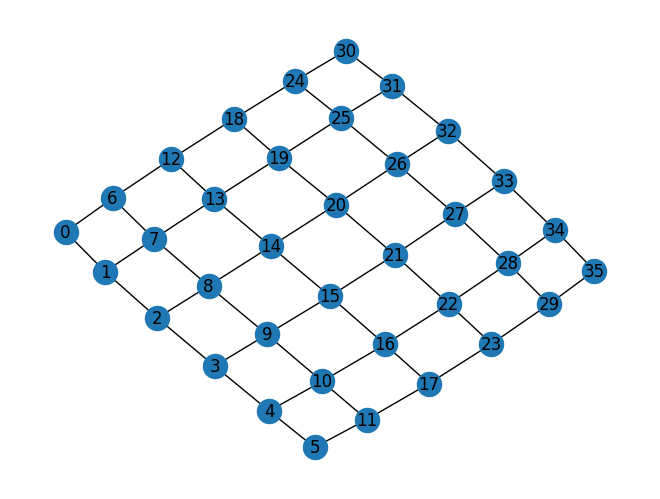

In [ ]:
# Example usage -- you must define `road_network` and `update_dynamic_edge_states` in your project.
# For demonstration we'll build a small random graph.
G = nx.grid_2d_graph(6, 6)
G = nx.convert_node_labels_to_integers(G)
# add some dummy edge attributes
for u, v in G.edges():
    G[u][v]['length'] = random.uniform(50, 500)
    G[u][v]['slope_deg'] = random.uniform(-5, 5)
    G[u][v]['congestion_factor'] = random.uniform(1.0, 1.5)
    G[u][v]['stop_prob'] = random.choice([0.0, 0.2])
    G[u][v]['speed_kph'] = random.choice([30, 50])
    G[u][v]['status'] = "open" if random.random() > 0.8 else "closed"

vehicle_params = {
    'mass_kg': 1850,
    'CdA': 0.62,
    'Cr': 0.015,
    'regen_eff': 0.65,
}


nx.draw(G, with_labels=True)
import matplotlib.pyplot as plt 
plt.show()

In [48]:
# compute embeddings once
embeddings = compute_spectral_embeddings(G, dim=6)

# build fleet environment
fleet_env = FleetEVEnv(G, vehicle_params, n_vehicles=2, embeddings=embeddings, debug=True)

# Wrap with VecNormalize + DummyVecEnv
def make_fleet():
    return fleet_env
vec_env = DummyVecEnv([make_fleet])
vec_env = VecMonitor(vec_env)
vec_env = VecNormalize(vec_env, norm_obs=True, norm_reward=True, clip_obs=10.)

log_dir = "./logs_ev"
os.makedirs(log_dir, exist_ok=True)

model = PPO(
    policy="MlpPolicy",
    env=vec_env,
    verbose=1,
    tensorboard_log=log_dir,
    device="cuda",
    learning_rate=1e-4,
    ent_coef=0.02,
    n_steps=1024,
    batch_size=128,
    n_epochs=10,
    gamma=0.99,
    )

#cb = TrainingDebugCallback(eval_env=fleet_env, print_freq=1, eval_freq=5000)

model.learn(total_timesteps=150_000)#, callback=cb)
model.save("ppo_ev_fleet")

Using cuda device
Logging to ./logs_ev\PPO_7


c:\Users\YODA\AppData\Local\pypoetry\Cache\virtualenvs\ev-energy-optimization-SsceYLpY-py3.12\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(
c:\Users\YODA\AppData\Local\pypoetry\Cache\virtualenvs\ev-energy-optimization-SsceYLpY-py3.12\Lib\site-packages\stable_baselines3\common\on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor 

-----------------------------
| time/              |      |
|    fps             | 475  |
|    iterations      | 1    |
|    time_elapsed    | 2    |
|    total_timesteps | 1024 |
-----------------------------
------------------------------------------
| time/                   |              |
|    fps                  | 396          |
|    iterations           | 2            |
|    time_elapsed         | 5            |
|    total_timesteps      | 2048         |
| train/                  |              |
|    approx_kl            | 0.0045904377 |
|    clip_fraction        | 0.00137      |
|    clip_range           | 0.2          |
|    entropy_loss         | -2.77        |
|    explained_variance   | -0.0181      |
|    learning_rate        | 0.0001       |
|    loss                 | 0.518        |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.00443     |
|    value_loss           | 1.04         |
------------------------------------------
----------------

In [ ]:
# Quick evaluation
mean_reward, std_reward = evaluate_policy(model, fleet_env, n_eval_episodes=2, deterministic=True)
print(f"Final eval mean_reward={mean_reward:.4f} std={std_reward:.4f}")

# Test single rollout
obs, _ = fleet_env.reset()
done = False
step = 0
while not done and step < 200:
    action = [int(a) for a in (model.predict(obs, deterministic=True)[0].flatten() if hasattr(model.predict(obs, deterministic=True)[0], 'flatten') else model.predict(obs, deterministic=True)[0])]
    # model.predict on MultiDiscrete/DummyVecEnv may return different shapes; we handle both
    obs, reward, done, _, _ = fleet_env.step(action)
    step += 1
    if step % 10 == 0:
        fleet_env.render()

print('Demo finished.')

In [99]:
model = PPO.load("ppo_ev_fleet")
obs, _ = fleet_env.reset()
done = False
step = 0

# Initialize paths for each vehicle
vehicle_paths = [[] for _ in range(fleet_env.n_vehicles)]
vehicle_starts = [v['current'] for v in fleet_env.vehicles]
vehicle_targets = [v['dst'] for v in fleet_env.vehicles]

while not done and step < 200:
    # Predict actions
    raw_action = model.predict(obs, deterministic=True)[0]
    if hasattr(raw_action, 'flatten'):
        action = [int(a) for a in raw_action.flatten()]
    else:
        action = [int(a) for a in raw_action]

    # Step environment
    obs, reward, done, _, _ = fleet_env.step(action)
    
    # Record current node for each vehicle
    for v_idx in range(fleet_env.n_vehicles):
        vehicle_paths[v_idx].append(fleet_env.vehicles[v_idx]['current'])
    
    step += 1
    if step % 5 == 0:
        fleet_env.render()

# Print paths with start and target
for v_idx, path in enumerate(vehicle_paths):
    print(f"Vehicle {v_idx}: start={vehicle_starts[v_idx]}, target={vehicle_targets[v_idx]}, path={path}")

print('Demo finished.')

Veh 0: cur=3 dst=6 energy=0.0610
Veh 1: cur=30 dst=23 energy=0.0000
Veh 0: cur=3 dst=6 energy=0.0610
Veh 1: cur=30 dst=23 energy=0.0000
Veh 0: cur=3 dst=6 energy=0.0610
Veh 1: cur=30 dst=23 energy=0.0000
Veh 0: cur=3 dst=6 energy=0.0610
Veh 1: cur=30 dst=23 energy=0.0000
Veh 0: cur=3 dst=6 energy=0.0610
Veh 1: cur=30 dst=23 energy=0.0000
Veh 0: cur=3 dst=6 energy=0.0610
Veh 1: cur=30 dst=23 energy=0.0000
Veh 0: cur=3 dst=6 energy=0.0610
Veh 1: cur=30 dst=23 energy=0.0000
Veh 0: cur=3 dst=6 energy=0.0610
Veh 1: cur=30 dst=23 energy=0.0000
Veh 0: cur=3 dst=6 energy=0.0610
Veh 1: cur=30 dst=23 energy=0.0000
Veh 0: cur=3 dst=6 energy=0.0610
Veh 1: cur=30 dst=23 energy=0.0000
Veh 0: cur=3 dst=6 energy=0.0610
Veh 1: cur=30 dst=23 energy=0.0000
Veh 0: cur=3 dst=6 energy=0.0610
Veh 1: cur=30 dst=23 energy=0.0000
Veh 0: cur=3 dst=6 energy=0.0610
Veh 1: cur=30 dst=23 energy=0.0000
Veh 0: cur=3 dst=6 energy=0.0610
Veh 1: cur=30 dst=23 energy=0.0000
Veh 0: cur=3 dst=6 energy=0.0610
Veh 1: cur=30 d